<a href="https://colab.research.google.com/github/KirillYd/stamp_recognition/blob/text_recognition/%22CRNN_text_recognition2%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import math
import string

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
print(tf.__version__)
import tensorflow.keras.backend as K
from tensorflow.keras.backend import get_value, ctc_decode
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Nadam

from google.colab import drive

drive.mount('/content/drive')

2.17.0
Mounted at /content/drive


Data generator

In [2]:
import os

import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

import torch
from torch.utils.data import Dataset, DataLoader

def generate_text(alphabet, seq_len=(2, 20)):
    seq_len = np.random.randint(seq_len[0], seq_len[1]+1)
    text = ''.join([np.random.choice(list(set(alphabet+alphabet.upper()))) for _ in range(seq_len)])

    while len(text.strip()) == 0:
        text = ''.join([np.random.choice(list(set(alphabet+alphabet.upper()))) for _ in range(seq_len)])

    r = np.random.rand()
    if r < 0.2:
        text = text.upper()
    elif r < 0.5:
        text = text.capitalize()
    else:
        text = text.lower()

    return text.strip()

def get_text_dimensions(text_string, font):
    ascent, descent = font.getmetrics()

    text_width = font.getmask(text_string).getbbox()[2]
    text_height = font.getmask(text_string).getbbox()[3] + descent

    return (text_width, text_height)

def safe_convert_to_grayscale(image_to_convert):
    if len(image_to_convert.shape) == 2:
        return image_to_convert
    if len(image_to_convert.shape) == 3:
        if image_to_convert.shape[2] == 1:
            return image_to_convert[:, :, 0]
        if image_to_convert.shape[2] == 3:
            return cv2.cvtColor(image_to_convert, cv2.COLOR_BGR2GRAY)
        if image_to_convert.shape[2] == 4:
            return cv2.cvtColor(image_to_convert, cv2.COLOR_BGRA2GRAY)

    raise ValueError('invalid shape')


def draw_underlined_text(draw, pos, text, font, **options):
    twidth, theight = get_text_dimensions(text, font)
    lx, ly = pos[0], pos[1] + theight

    width = theight // 5

    draw.text(pos, text, font=font, **options)
    draw.line((lx, ly, lx + twidth, ly), width=width, **options)

def draw_overlined_text(draw, pos, text, font, **options):
    twidth, theight = get_text_dimensions(text, font)
    lx, ly = pos[0], pos[1]

    width = theight // 10

    draw.text(pos, text, font=font, **options)
    draw.line((lx, ly, lx + twidth, ly), width=width, **options)


def rotate_image(image, angle):
    if angle == 0:
        return image
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)

    delta_x = np.ceil(abs(rot_mat[0, 2])).astype(int)
    delta_y = np.ceil(abs(rot_mat[1, 2])).astype(int)

    image = cv2.copyMakeBorder(image, delta_y*2, delta_y*2, delta_x*2, delta_x*2, cv2.BORDER_CONSTANT, value=255)

    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    result = result[delta_y: -delta_y, delta_x: -delta_x]
    return result


def add_salt_pepper_noise(image, salt_color, pepper_color, salt_p=0.025, pepper_p=0.025):
    salt_mask = np.random.rand(*image.shape[:2])
    salt_mask[salt_mask < 1-salt_p] = 0
    salt_mask[salt_mask > 0] = 1

    pepper_mask = np.random.rand(*image.shape[:2])
    pepper_mask[pepper_mask < 1-pepper_p] = 0
    pepper_mask[pepper_mask > 0] = 1

    image[salt_mask.astype(bool)] = salt_color
    image[pepper_mask.astype(bool)] = pepper_color

    return image


def prepare_segment_for_recognition(segment, target_shape=(32, 256), pad_value=255):
    segment = safe_convert_to_grayscale(segment)

    coef = min(target_shape[0] / segment.shape[0], target_shape[1] / segment.shape[1])

    segment = cv2.resize(segment, dsize=None, fx=coef, fy=coef, interpolation=cv2.INTER_AREA if coef < 1 else cv2.INTER_CUBIC)
    left = target_shape[1]-segment.shape[1]
    top = target_shape[0]-segment.shape[0]
    segment = cv2.copyMakeBorder(segment, 0, top, 0, left, cv2.BORDER_CONSTANT, value=(pad_value, pad_value, pad_value))

    return segment


def generate_sample(output_shape, alphabet, seq_len, bgs, fonts_path, pad_value):
    font_size = np.random.randint(12, 29)

    font = ImageFont.truetype(os.path.join(fonts_path, np.random.choice(os.listdir(fonts_path))), size=font_size)

    text = generate_text(alphabet, seq_len=seq_len)
    spaces_before = ' '*np.random.randint(0, 3)
    spaces_after = ' '*np.random.randint(0, 3)
    spaced_text = spaces_before + text + spaces_after
    text_w, text_h = get_text_dimensions(spaced_text, font)

    bg = np.full((text_h, text_w), dtype='uint8', fill_value=255)
    bg = Image.fromarray(bg)

    draw = ImageDraw.Draw(bg)

    fill = np.random.randint(0, 31)
    pos = (0, 0)

    r = np.random.random()
    if r < 0.1:
        draw_underlined_text(draw, pos, spaced_text, font, fill=fill)
    elif r < 0.2:
        draw_overlined_text(draw, pos, spaced_text, font, fill=fill)
    else:
        draw.text(pos, spaced_text, fill, font)

    img = np.array(bg)
    img = rotate_image(img, np.random.randint(-2, 3))

    if np.random.random() < 0.1 and img.shape[1] > font_size*2:
        img = img[:, font_size//4: -font_size//4]

    img = img[1:]

    if np.random.random() < 0.5:
        bg = np.full(img.shape[:2], dtype='uint8', fill_value=np.random.randint(230, 256))
    else:
        bg = bgs[np.random.randint(0, len(bgs))]
        if bg.shape[1] > img.shape[1] and bg.shape[0]> img.shape[0]:
            bg_x = np.random.randint(0, bg.shape[1]-img.shape[1]+1)
            bg_y = np.random.randint(0, bg.shape[0]-img.shape[0]+1)
            bg = bg[bg_y: bg_y+img.shape[0], bg_x: bg_x+img.shape[1]]
        else:
            bg = np.full_like(img, fill_value=np.random.randint(230, 256))

    img = np.minimum(img, bg)

    img = add_salt_pepper_noise(img, np.unique(bg)[0], fill)

    img = prepare_segment_for_recognition(img, output_shape, pad_value)

    return img, text.upper()

In [3]:
class OCRDataset(Dataset):
    def __init__(self, alphabet, output_shape, batch_size, num_steps, fonts_path='/content/drive/MyDrive/text_recognition/Data_gen/fonts', bgs_path='/content/drive/MyDrive/text_recognition/Data_gen/backgrounds'):
        super(Dataset, self).__init__()

        self.alphabet = alphabet
        self.batch_size = batch_size
        self.num_steps = num_steps
        self.output_shape = output_shape
        self.pad_value = 255
        self.fonts_path = fonts_path
        self.bgs = [cv2.imread(f'{bgs_path}/{fn}', cv2.IMREAD_GRAYSCALE) for fn in os.listdir(bgs_path)]

    def encode_text(self, text, seq_len, blank_idx=0):
        def _label_to_num(label):
            label_num = []
            for ch in label:
                idx = self.alphabet.find(ch)
                label_num.append(idx + (idx >= blank_idx))
            return np.array(label_num)

        if blank_idx < 0:
            blank_idx = len(self.alphabet)
        nums = np.full((seq_len,), fill_value=blank_idx, dtype='int32')
        nums[:len(text)] = _label_to_num(text)

        return nums

    def decode_target(self, nums, blank_idx=0):
        if blank_idx < 0:
            blank_idx = len(alphabet)
        nums_collapsed = [self.alphabet[idx-(idx >= blank_idx)] for idx in nums.cpu().detach().numpy() if idx != blank_idx]
        return ''.join(nums_collapsed)

    def decode_pred(self, logits, alphabet_idx, blank_idx=0):
        if blank_idx < 0:
            blank_idx = len(alphabet)
        nums = torch.argmax(logits, dim=-1)
        nums_collapsed = [self.alphabet[idx-(idx >= blank_idx)] for idx, _ in groupby(nums.cpu().detach().numpy()) if idx != blank_idx and idx < len(alphabet)]
        return ''.join(nums_collapsed)

    def __len__(self):
        return self.batch_size * self.num_steps

    def __getitem__(self, idx):
        image, text = generate_sample(output_shape=self.output_shape, alphabet=self.alphabet,
                                      seq_len=(3, 25), bgs=self.bgs, fonts_path=self.fonts_path, pad_value=self.pad_value)

        #image = torch.FloatTensor(image / 255).unsqueeze(0)
        #target = torch.IntTensor(self.encode_text(text, 32))

        return image, text

In [4]:
def collate_fn(batch):
    images, texts = zip(*batch)  # Распаковываем батч
    return list(images), list(texts)

from torch.utils.data import DataLoader, Dataset, random_split
alphabet = 'ЁАБВГДЕЖЗИЙКЛМНОПРСТУФХЦЧШЩЬЫЪЭЮЯ 0123456789!@№%?()-=+.,/«»:;~"<>[]'
batch_size = 64
num_steps = 100
output_shape=(32, 256)

dataset = OCRDataset(alphabet, output_shape, batch_size, num_steps)

loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers= 2)

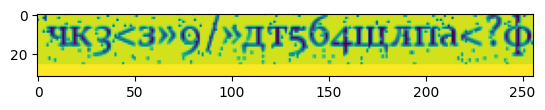

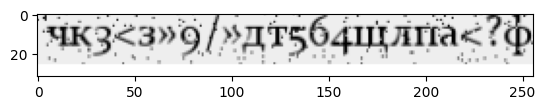

In [5]:
for image, text in loader:
  plt.imshow(image[0])
  plt.show()
  plt.imshow(image[0], cmap='gray')
  plt.show()
  break

# Prepare dataset

In [44]:
# Data preprocessing

def preprocess(img):
  for func in [resize_n_rotate]:
    img = func(img)
  return img.astype("float32")/255


def resize_n_rotate(img, shape_to=(32, 256)): #shepe_to 64, 800
  if img.shape[0] > shape_to[0] or img.shape[1] > shape_to[1]:
    shrink_multiplayer = min(math.floor(shape_to[0] / img.shape[0] * 100) / 100,
                             math.floor(shape_to[1] / img.shape[1] * 100) / 100)
    img = cv2.resize(img, None,
                     fx=shrink_multiplayer,
                     fy=shrink_multiplayer,
                     interpolation=cv2.INTER_AREA)

  img = cv2.copyMakeBorder(img, math.ceil(shape_to[0]/2) - math.ceil(img.shape[0]/2),
                           math.floor(shape_to[0]/2) - math.floor(img.shape[0]/2),
                           0, #math.ceil(shape_to[1]/2) - math.ceil(img.shape[1]/2)
                           math.floor(shape_to[1]) - math.floor(img.shape[1]), #math.floor(shape_to[1]/2) - math.floor(img.shape[1]/2)
                           cv2.BORDER_CONSTANT, value=255)
  return cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)


#def add_adaptiveThreshold(img):
#  return cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 21, 10).astype('bool') #THRESH_BINARY_INV


# Label encoding

def encode_text(texts):
  def _label_to_num(label, alphabet):
    label_num = []
    for ch in label:
      label_num.append(alphabet.find(ch))
    return np.array(label_num)

  alphabet = ''.join(sorted(pd.Series(texts).apply(list).apply(pd.Series).stack().unique()))

  nums = np.ones([len(texts), max([len(text) for text in texts])], dtype='int64') * len(alphabet)
  for i, text in enumerate(texts):
    nums[i][:len(text)] = _label_to_num(text, alphabet)

  return nums, alphabet

In [7]:
#image = np.random.rand(32, 256, 3) * 255  # Случайное цветное изображение
#img = cv2.imread("/content/drive/MyDrive/text_recognition/111.jpg", 0)
#print(img.shape)
#plt.imshow(img)
#plt.show()
#print(type(img))
#image = image.astype(np.uint8)
#print(image)
train_X, train_y = [], []
for image,text in loader:
  for i in range(len(image)):
    train_X.append(preprocess(image[i]))
    train_y.append(text[i])

train_X = np.array(train_X)
train_y, alphabet = encode_text(train_y)
alphabet


' !"%()+,-./0123456789:;<=>?@[]~«»ЁАБВГДЕЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ№'

In [8]:
train_X, val_X, train_y, val_y  = train_test_split(train_X, train_y, test_size=0.2, random_state=42)
train_X, test_X, train_y, test_y  = train_test_split(train_X, train_y, test_size=0.25, random_state=42)

In [9]:
print("train_X shape:", train_X.shape)  # Ожидается (количество_примеров, 512, 64, 1)
print("train_y shape:", train_y.shape)  # Ожидается (количество_примеров, длина_последовательности)
print("val_X shape:", val_X.shape)      # Ожидается (количество_примеров, 512, 64, 1)
print("val_y shape:", val_y.shape)      # Ожидается (количество_примеров, длина_последовательности)

train_X shape: (3840, 256, 32)
train_y shape: (3840, 25)
val_X shape: (1280, 256, 32)
val_y shape: (1280, 25)


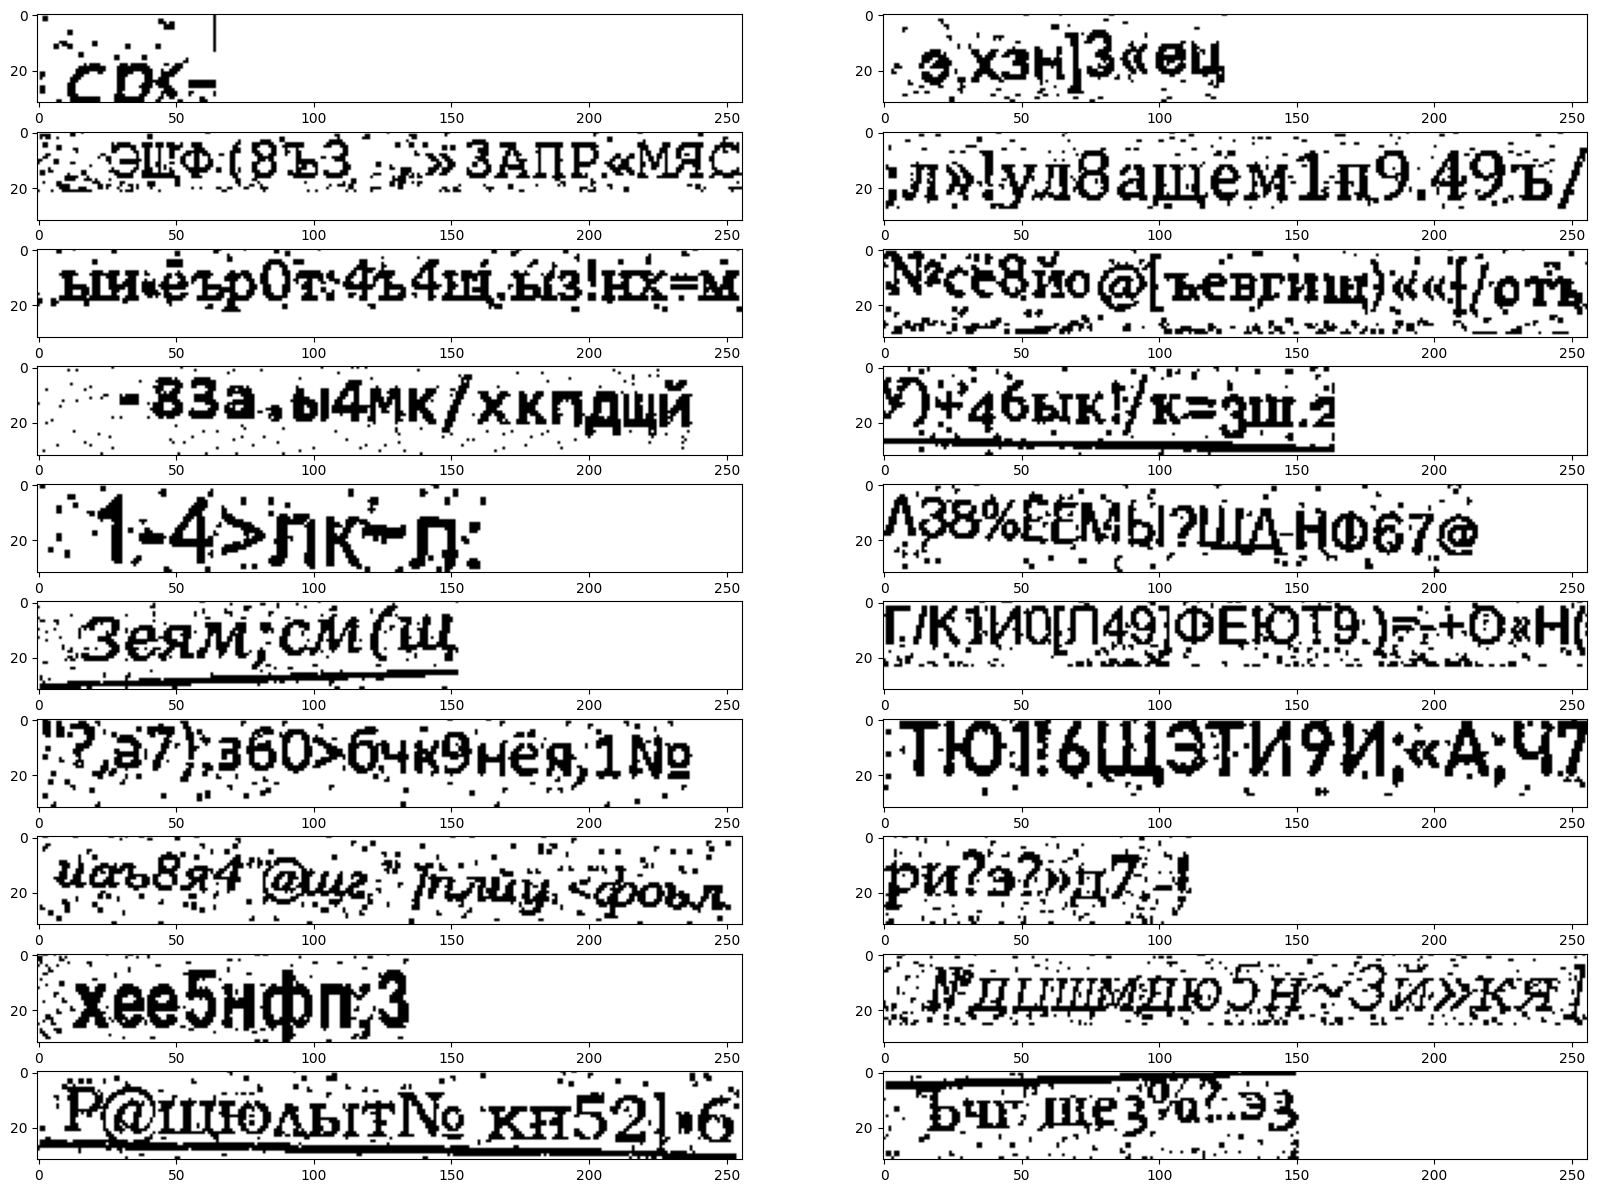

In [10]:
fig, axes = plt.subplots(figsize=(20, 15), ncols=2, nrows=10)

# Preprocess example

for i in range(10):
  for j in range(2):
    axes[i, j % 2].imshow(cv2.rotate(
        (train_X[i * 2 + j % 2]).astype(np.uint8),cv2.ROTATE_90_COUNTERCLOCKWISE),
        cmap='gray')

# Model

In [11]:
class CERMetric(tf.keras.metrics.Metric):
    """
    A custom Keras metric to compute the Character Error Rate
    """
    def __init__(self, name='CER_metric', **kwargs):
        super(CERMetric, self).__init__(name=name, **kwargs)
        self.cer_accumulator = self.add_weight(name="total_cer", initializer="zeros")
        self.counter = self.add_weight(name="cer_count", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        input_shape = K.shape(y_pred)
        input_length = tf.ones(shape=input_shape[0]) * K.cast(input_shape[1], 'float32')

        decode, log = K.ctc_decode(y_pred, input_length, greedy=True)

        decode = K.ctc_label_dense_to_sparse(decode[0], K.cast(input_length, 'int32'))
        y_true_sparse = K.ctc_label_dense_to_sparse(y_true, K.cast(input_length, 'int32'))
        y_true_sparse = tf.sparse.retain(y_true_sparse, tf.not_equal(y_true_sparse.values, tf.math.reduce_max(y_true_sparse.values)))

        decode = tf.sparse.retain(decode, tf.not_equal(decode.values, -1))
        distance = tf.edit_distance(decode, y_true_sparse, normalize=True)

        self.cer_accumulator.assign_add(tf.reduce_sum(distance))
        self.counter.assign_add(K.cast(tf.shape(y_true)[0], 'float32'))

    def result(self):
        return tf.math.divide_no_nan(self.cer_accumulator, self.counter)

    def reset_state(self):
        self.cer_accumulator.assign(0.0)
        self.counter.assign(0.0)


def CTCLoss(y_true, y_pred):
    """
    Compute the training-time loss value
    """
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = K.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [12]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', activation=LeakyReLU(alpha=0.01), input_shape=(256, 32, 1))) #tf.keras.layers.LeakyReLU
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), padding='same', activation=LeakyReLU(alpha=0.01)))
model.add(MaxPooling2D((1, 2)))

model.add(Conv2D(128, (3, 3), padding='same', activation=LeakyReLU(alpha=0.01)))
model.add(MaxPooling2D((2, 2)))
#model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), padding='same', activation=LeakyReLU(alpha=0.01)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (3, 3), padding='same', activation=LeakyReLU(alpha=0.01)))
model.add(MaxPooling2D((1, 2)))
model.add(BatchNormalization()) # x 1 x ..

model.add(Reshape((-1, 256)))

model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Bidirectional(LSTM(128, return_sequences=True)))

model.add(Dense(len(alphabet) + 1, activation='softmax')) # +1 for ctc blank

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 256, 32, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 16, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 16, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 128, 8, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 128, 8, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 64, 4, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 4, 128)          │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 32, 2, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 2, 256)          │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 32, 1, 256)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 1, 256)          │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 32, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 32, 256)             │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 32, 256)             │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32, 68)              │          17,476 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,342,404 (5.12 MB)

 Trainable params: 1,341,892 (5.12 MB)

 Non-trainable params: 512 (2.00 KB)

In [13]:
model.compile(optimizer=Nadam(learning_rate=0.001, clipnorm=1.0), loss=CTCLoss, metrics=[CERMetric()])

# Train model

In [16]:
checkpoint_path = "/content/drive/MyDrive/text_recognition/checkpoints/cp5.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Создаем колбек контрольной точки
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


history = model.fit(train_X, train_y, validation_data=(val_X, val_y),
                    epochs=75, batch_size=64,
                    callbacks=[EarlyStopping(patience=10, restore_best_weights=True, monitor='val_CER_metric', mode='min'),
                              ReduceLROnPlateau(factor=0.5, min_lr=1e-5, patience=4, monitor='val_CER_metric'),
                              cp_callback],
                    verbose=1)

model.save('/content/drive/MyDrive/text_recognition/model/crnn0711.h5')

Epoch 1/75
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - CER_metric: 0.9963 - loss: 70.0308
Epoch 1: saving model to /content/drive/MyDrive/text_recognition/checkpoints/cp5.weights.h5
60/60 ━━━━━━━━━━━━━━━━━━━━ 25s 160ms/step - CER_metric: 0.9963 - loss: 69.9220 - val_CER_metric: 1.0000 - val_loss: 65.1936 - learning_rate: 0.0010
Epoch 2/75
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - CER_metric: 1.0000 - loss: 59.4889
Epoch 2: saving model to /content/drive/MyDrive/text_recognition/checkpoints/cp5.weights.h5
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - CER_metric: 1.0000 - loss: 59.4761 - val_CER_metric: 1.0050 - val_loss: 69.6918 - learning_rate: 0.0010
Epoch 3/75
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - CER_metric: 0.9814 - loss: 52.0582
Epoch 3: saving model to /content/drive/MyDrive/text_recognition/checkpoints/cp5.weights.h5
60/60 ━━━━━━━━━━━━━━━━━━━━ 13s 168ms/step - CER_metric: 0.9807 - loss: 51.9981 - val_CER_metric: 0.9986 - val_loss: 69.9207 - learning_rate: 0.0010
Epoch 4/75
60/60

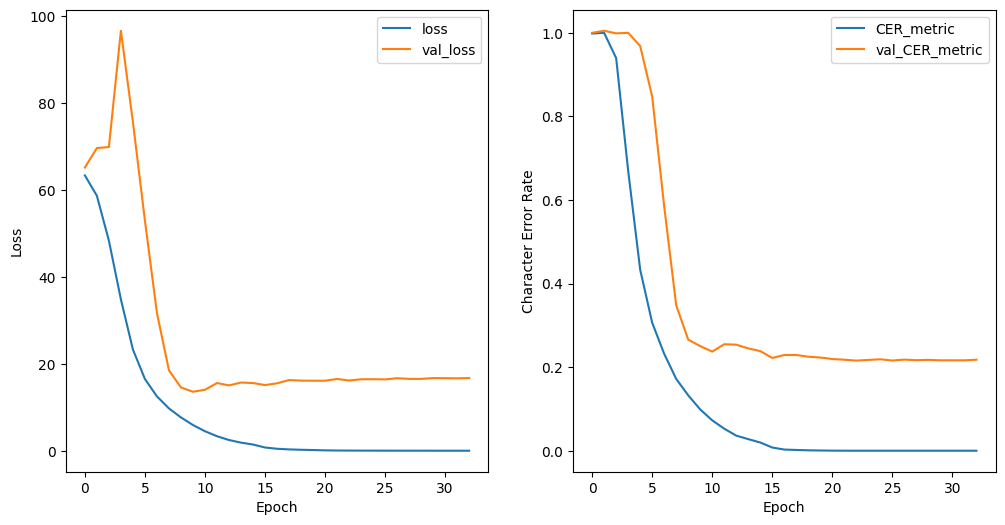

In [17]:
fig, axes = plt.subplots(figsize=(12, 6), ncols=2, nrows=1)

axes[0].plot(history.history['loss'], label='loss')
axes[0].plot(history.history['val_loss'], label='val_loss')
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[1].plot(history.history['CER_metric'], label='CER_metric')
axes[1].plot(history.history['val_CER_metric'], label='val_CER_metric')
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Character Error Rate")
axes[1].legend()

plt.show()

In [ ]:
model.save('./crnn2.h5')

In [ ]:
model.save('/content/drive/MyDrive/text_recognition/model/crnn2.h5')

In [ ]:
model.save('/content/drive/MyDrive/text_recognition/model/crnn2.keras')

**Загрузка весов модели**

In [14]:
model.load_weights('/content/drive/MyDrive/text_recognition/checkpoints/cp5.weights.h5') #

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'nadam', because it has 2 variables whereas the saved optimizer has 55 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## Model training results

In [15]:
# Test results: (loss, cer)

model.evaluate(test_X, test_y)

40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - CER_metric: 0.2120 - loss: 16.3872


[16.535465240478516, 0.21381798386573792]

In [16]:
# Decode label for single image

def num_to_label(num, alphabet):
    text = ""
    for ch in num:
        if ch == len(alphabet): # ctc blank
          break
        else:
          text += alphabet[ch]
    return text


# Decode labels for softmax matrix

def decode_text(nums):
  values = get_value(
      ctc_decode(nums, input_length=np.ones(nums.shape[0])*nums.shape[1],
                 greedy=True)[0][0])

  texts = []
  for i in range(nums.shape[0]):
    value = values[i]
    texts.append(num_to_label(value[value >= 0], alphabet))
  return texts

In [17]:
predicts = model.predict(test_X)
predicts = decode_text(predicts)

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


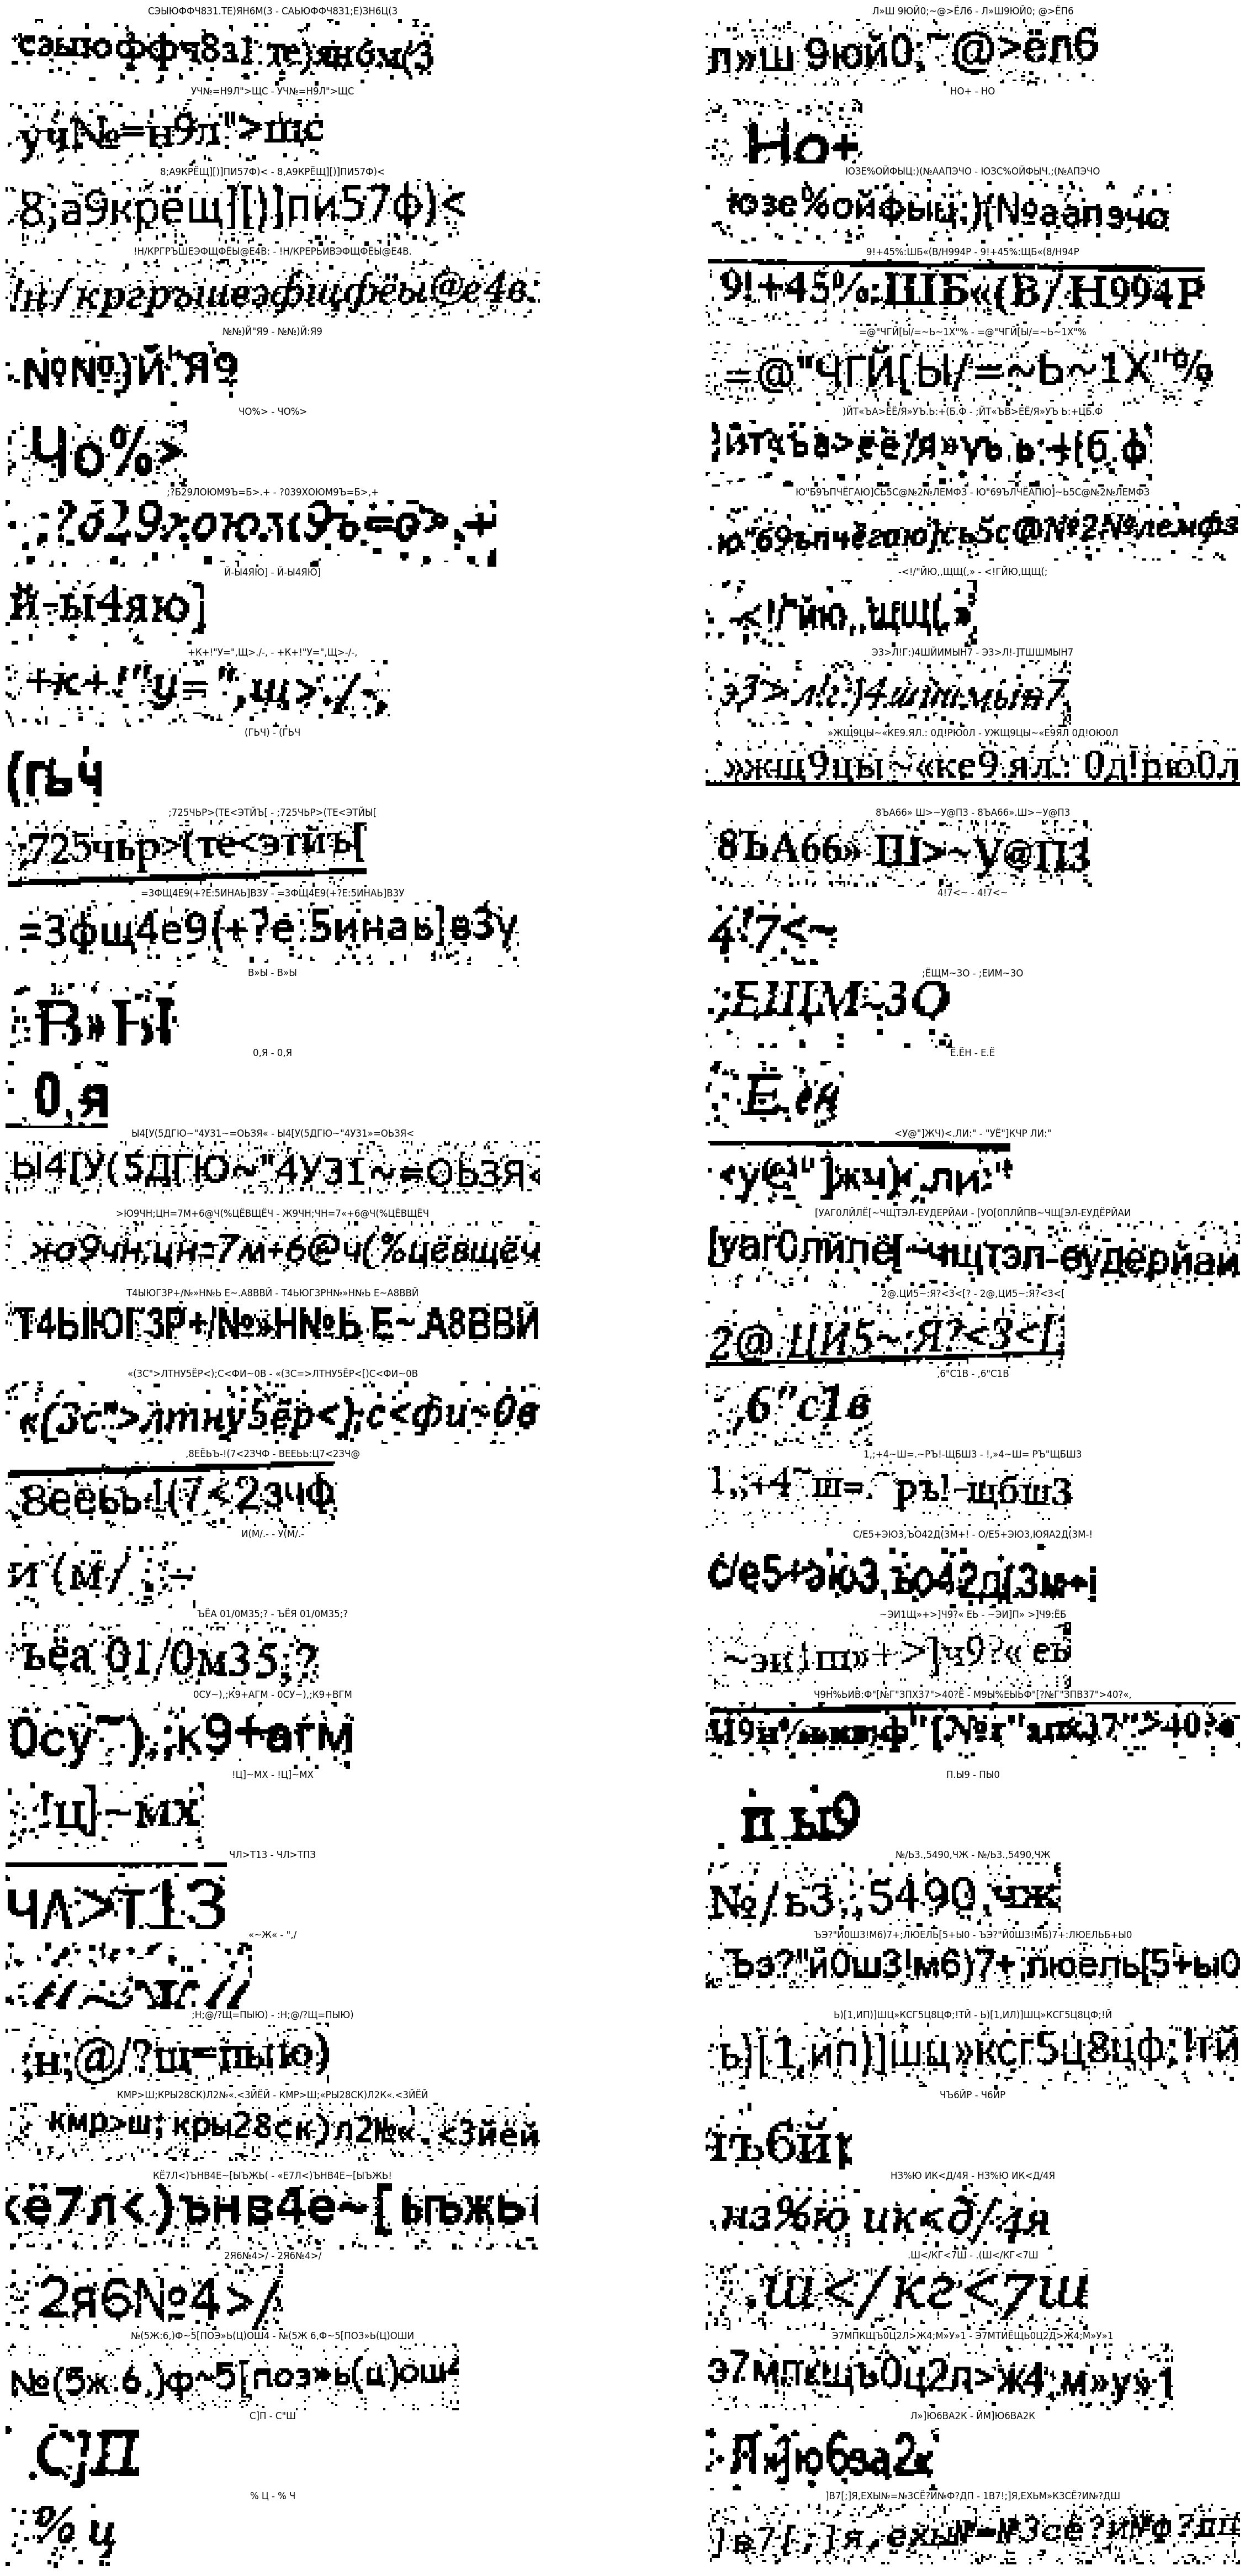

In [18]:
# Prediction results

fig, axes = plt.subplots(figsize=(30, 60), ncols=2, nrows=32)

test_X = test_X.astype('int')

# Title format: GT - Predict
for i in range(64):
  axes[i // 2, i % 2].imshow(cv2.rotate(
      (test_X[i]).astype(np.uint8),cv2.ROTATE_90_COUNTERCLOCKWISE),
      cmap='gray')
  axes[i // 2, i % 2].set_title(
      f'{num_to_label(test_y[i], alphabet)} - {predicts[i]}')
  axes[i // 2, i % 2].axis("off")

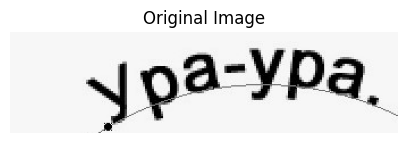

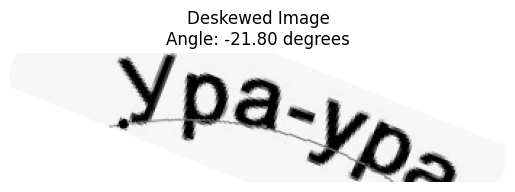

In [47]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
# Загрузка изображения
img = cv2.imread("/content/drive/MyDrive/text_recognition/test.jpg")
# Отображение оригинального изображения
plt.figure(figsize=(5, 5))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')
plt.show()
# Преобразование в оттенки серого и размывание
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (9, 9), 0)
# Изменение размера изображения
resized_height = 480
percent = resized_height / len(img)
resized_width = int(percent * len(img[0]))
gray = cv2.resize(gray, (resized_width, resized_height))
# Рисование прямоугольника
start_point = (0, 0)
end_point = (gray.shape[1], gray.shape[0])  # Изменено на (gray.shape[1], gray.shape[0])
color = (255, 255, 255)
thickness = 10
gray = cv2.rectangle(gray, start_point, end_point, color, thickness)
# Инвертирование изображения
gray = cv2.bitwise_not(gray)
# Применение порогового значения
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
# Морфологическая обработка
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 5))
dilate = cv2.dilate(thresh, kernel)
# Поиск контуров
contours, hierarchy = cv2.findContours(dilate, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
angles = []
for contour in contours:
    minAreaRect = cv2.minAreaRect(contour)
    angle = minAreaRect[-1]
    if angle != 90.0 and angle != -0.0:  # фильтрация 0 и 90
        angles.append(angle)
# Вычисление среднего угла
angles.sort()
if angles:
    mid_angle = angles[int(len(angles) / 2)]
else:
    mid_angle = 0  # Если углы не найдены, устанавливаем угол в 0
# Коррекция угла
if mid_angle > 45:  # против часовой стрелки
    mid_angle = -(90 - mid_angle)
# Получение размеров оригинального изображения
height = img.shape[0]
width = img.shape[1]
# Применение поворота
m = cv2.getRotationMatrix2D((width / 2, height / 2), mid_angle, 1)
deskewed = cv2.warpAffine(img, m, (width, height), borderValue=(255, 255, 255))
cv2.imwrite("/content/drive/MyDrive/text_recognition/deskewed.jpg", deskewed)

plt.imshow(cv2.cvtColor(deskewed, cv2.COLOR_BGR2RGB))
plt.title('Deskewed Image\nAngle: {:.2f} degrees'.format(mid_angle))
plt.axis('off')
plt.show()


[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
[[2.62818389e-06 6.78402512e-06 6.79808591e-06 ... 1.27690773e-05
  4.17984523e-07 9.98391449e-01]
 [4.20796056e-08 8.81268392e-08 3.28381411e-08 ... 2.06080699e-08
  6.33221431e-09 9.99962807e-01]
 [1.73365267e-09 2.13669193e-09 3.20926036e-10 ... 2.29400998e-10
  2.79980206e-10 9.99997497e-01]
 ...
 [1.07239176e-10 1.42074053e-09 3.52751404e-11 ... 2.18028109e-10
  3.01476644e-09 9.99999881e-01]
 [4.66159000e-10 4.54308413e-09 1.14027975e-10 ... 4.82635432e-10
  8.14016410e-09 9.99999762e-01]
 [7.62685914e-09 8.74032366e-08 2.54764654e-09 ... 1.00566497e-08
  1.21163851e-07 9.99993920e-01]]


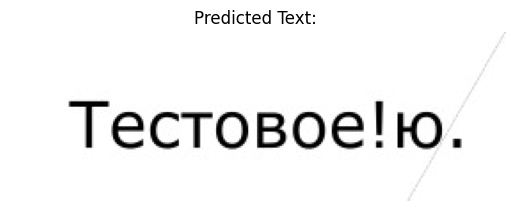

In [45]:

#predicts = decode_text(pred_img)



img_path = "/content/drive/MyDrive/text_recognition/test17.jpg"
img = cv2.imread(img_path, 0)

processed_img = preprocess(img)
print(processed_img)
input_data = np.array([processed_img])

pred_img = model.predict(input_data)
print(pred_img[0])
predictions = decode_text(pred_img)

plt.imshow(img, cmap='gray')
plt.title(f'Predicted Text: {predictions[0]}')
plt.axis('off')
plt.show()

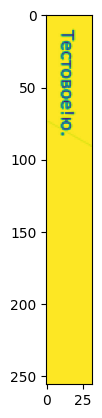

In [46]:
plt.imshow(processed_img)